In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import cv2
from src.data_transformation import DataTransformer
import matplotlib.pyplot as plt

2024-03-22 19:05:34.146176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 19:05:34.146217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 19:05:34.147256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 19:05:34.153795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 19:05:35.058615: W tensorflow/compiler/tf2

In [3]:
# Setup mediapipe instance
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [4]:
pose_model = mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

I0000 00:00:1711127136.621864   46216 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1711127136.659734   47862 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2


In [5]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle

In [6]:
obj = DataTransformer("bicep","poses")
def convertCycleToSequence(cycle):
    seq = []
    for frame in cycle:
        poses = obj.get_frame_poses(frame)
        if poses == None:
            continue
        seq.append(poses)
    return np.array(seq)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1711127136.691827   46216 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1711127136.705587   47879 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2


In [7]:
import numpy as np

def euclidean_distance(v1, v2):
    """
    Compute the Euclidean distance between two vectors.
    
    Parameters:
        v1 (numpy.ndarray): First vector.
        v2 (numpy.ndarray): Second vector.
        
    Returns:
        float: Euclidean distance between the two vectors.
    """
    return np.linalg.norm(v1 - v2)

def dtw_distance(s1, s2):
    """
    Compute the Dynamic Time Warping (DTW) distance between two sequences of vectors.
    
    Parameters:
        s1 (numpy.ndarray): First sequence of vectors (2D array).
        s2 (numpy.ndarray): Second sequence of vectors (2D array).
        
    Returns:
        float: DTW distance between the two sequences.
    """
    # Calculate the length of each sequence
    n, m = len(s1), len(s2)
    
    # Initialize the DTW matrix with zeros
    dtw_matrix = np.zeros((n + 1, m + 1))
    
    # Fill the first row and column of the matrix with infinity
    dtw_matrix[0, 1:] = np.inf
    dtw_matrix[1:, 0] = np.inf
    
    # Calculate the DTW matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = euclidean_distance(s1[i - 1], s2[j - 1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])
    
    # Return the DTW distance
    return dtw_matrix[n, m]

# Example usage:
# Define two sequences of vectors
sequence1 = np.array([[1, 2], [3, 4], [2, 3], [4, 5], [3, 4]])
sequence2 = np.array([[1, 2], [2, 3], [2, 3], [2, 3], [3, 4]])

# Calculate the DTW distance between the sequences
distance = dtw_distance(sequence1, sequence2)
print("DTW distance:", distance)


DTW distance: 2.8284271247461903


In [1]:
# Initialize VideoCapture
cap = cv2.VideoCapture(0)
#cap = cv2.VideoCapture("/media/amro/944A72844A726342/E-JUST/Mine/Year3/S1/Seminar/Datasets/archive/Original Datasets/Bicep Curl/g1/g1_bicepcurl_1.mp4")
#cap = cv2.VideoCapture("/media/amro/944A72844A726342/E-JUST/Mine/Year3/S1/Seminar/Datasets/archive/Original Datasets/Bicep Curl/g1/g1_bicepcurl_5.mp4")
# Initialize variables to store subvideos
subvideos = []
subvideo_frames = []

# Curl counter variables
counter = 0 
stage = None

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            
            # Calculate angle
            angle = calculate_angle(shoulder, elbow, wrist)
            
            # Curl counter logic
            if angle > 160:
                stage = "down"
            if angle < 80 and stage =='down':
                stage="up"
                counter +=1
                print(counter)
                
                # Start a new cycle
                if subvideo_frames:
                    subvideos.append(np.array(subvideo_frames))  # Save subvideo frames to subvideos list
                    subvideo_frames = []  # Clear subvideo frames for the next cycle
                       
        except Exception as e:
            print("Error:", e)
            pass
        
        # Append frame to current subvideo
        subvideo_frames.append(image.copy())
        # Visualize angle
        cv2.putText(image, str(angle), 
                       tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                            )
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # Append last subvideo frames
    if subvideo_frames:
        subvideos.append(np.array(subvideo_frames))
        
    # Release resources
    cap.release()
    cv2.destroyAllWindows()


NameError: name 'cv2' is not defined

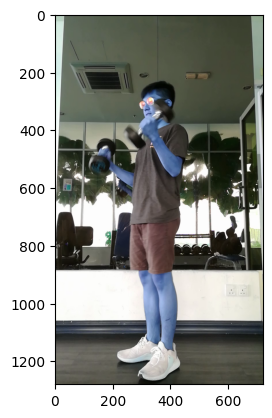

In [22]:
plt.imshow(subvideos[1][10])

In [14]:
subvideos[1].shape,subvideos[2].shape

((60, 1280, 720, 3), (58, 1280, 720, 3))

In [2]:
obj = DataTransformer("bicep","poses")

I0000 00:00:1711122529.982938   44752 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1711122530.017719   44828 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [21]:
c1 = subvideos[0]
s1 = convertCycleToSequence(subvideos[0])
s1.shape

(21, 24)

In [22]:
c2 = subvideos[1]
s2 = convertCycleToSequence(subvideos[1])
s2.shape

(60, 24)

In [23]:
dtw_distance(s1, s2)

11.184326015725006

In [37]:
#new video
c3 = subvideos[0]
s3 = convertCycleToSequence(subvideos[0])
s3.shape

(21, 24)

In [39]:
dtw_distance(s2, s3)

21.378631880098656

In [30]:
s3.shape

(51, 24)

In [14]:
len(subvideos)

3